# Finding Donors for Charity ML

### This is my extended solution for Udacity's Data Scientist Nanodegree first project

## Introduction

Determining the income from indirect data is a powerful tool for customer base identification. In this project we employed several supervised learning algorithms to infer income from the 1994 census data contained in the Adults dataset [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income) This datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_.

The goal of this project is to build a model that can predict whether an individual makes more or less than $50,000 annually. After preprocessing the dataset and dividing it into training and testing subsets, we proceeded to test several supervised learning models in order to choose which one led to higher prediction scores. Next, we optimized the hyperparameters of the chosen model and finally we performed feature importance analysis to determine which variables were the most relevant for income prediction.  

## Loading data and EDA

We first loaded the libraries and the data and performed some exploratory data analisys.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
%matplotlib inline

In [60]:
from warnings import filterwarnings
filterwarnings('ignore')

In [61]:
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

In [52]:
from itertools import product

In [4]:
# read data from data folder
data = pd.read_csv('data/census.csv')
data.head(n=5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [6]:
# general information about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


#### The dataset has 45222 records and 14 features. Entries are numerical (int64 and float64) or categorical (object) and there are no missing values.

#### The features are:

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [7]:
# 5-number data summary
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


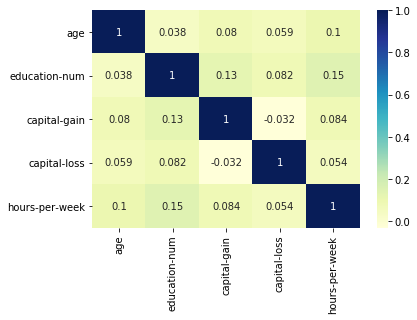

In [8]:
# Pearson's correlation coefficient for numerical variables
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu");

#### Some of the features are weakly correlated. It is unlikely this will affect the interpretation of the model.

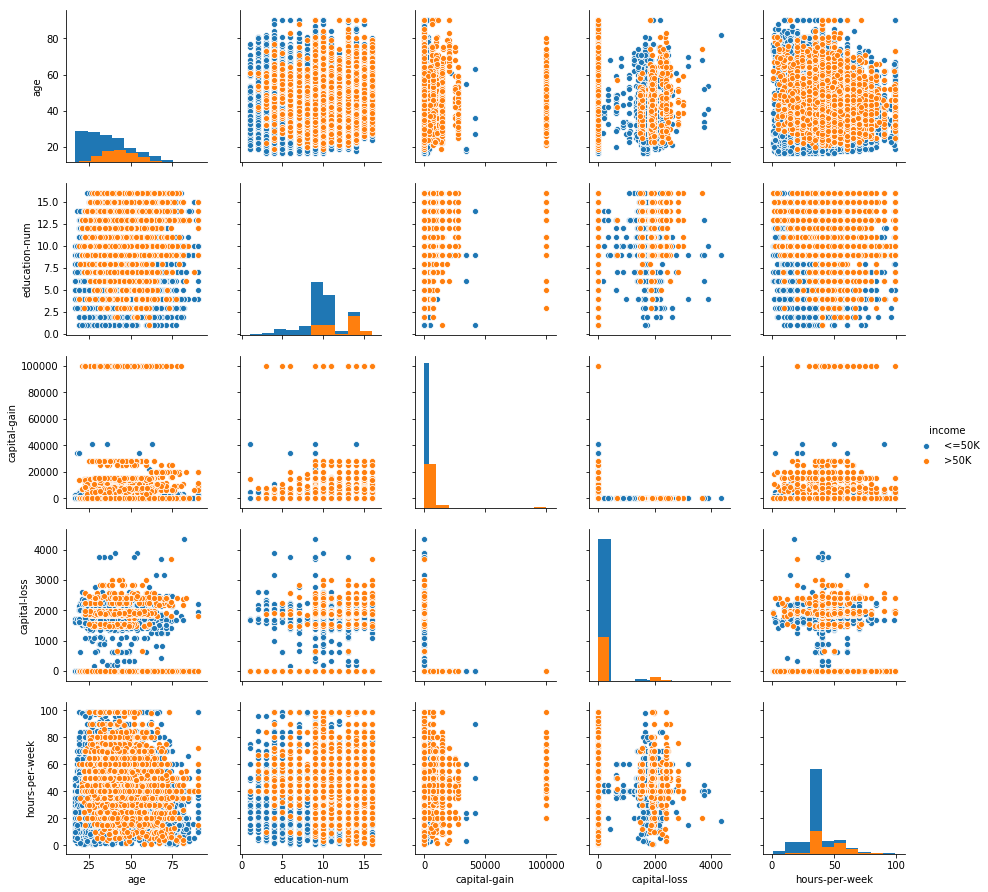

In [14]:
# visually inspect all combinations of numerical variables
sns.pairplot(data, hue='income', diag_kind='hist');

#### None of the features follow a Normal distribution. Capital-gain shows a hight amount of outliers at 99999 but these will be kept. The following pairs show some weak dependence:

- Age and capital-gain
- education-num and hours-per-week

## Preparing the data

The first step of data preparation consisted in separating the target (income) from the other features. Two classification levels were created:

* income more that \$50,000 
* income at most \$50,000

In [15]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K']['income'].count()

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K']['income'].count()

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


In [16]:
# consistency check
n_records == n_greater_50k + n_at_most_50k 

True

**Only 25% of the entries earn more than 50K. This means that the dataset is skewed and accuracy is not a good metric for this problem. Despite presenting both accuracy and F1 score, we based our decisions in the latter.**

Next, we created a new pandas series with the income data and dropped this column from the main dataframe.

In [28]:
# separate target column from dataset for preprocessing. 
income_raw = data['income']
# define new dataframe without target column.
features_raw = data.drop('income', axis=1)

# Map target column from strings to (0,1) range.
# Incomes >50K map to 1
income = income_raw.map(lambda x: 0 if x=='<=50K' else 1)

#### As shown in the pairplot, capital-gain and capital-loss have outliers which can skew the model predictions. 

**Note:** The rubric of the project suggested applying a log transformation in order to reduce the skewness of these features. After submitting the project I ran the notebook without this transformation and found little difference for the final result. I finally decided to keep the transformation only for completeness. 

In [18]:
# Create new dataframe containing log-transformed skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1.0))

### Normalizing Numerical Features

With the data cleaned (it was very straightforward for this project since the data was already sanitized), we proceeded with the scaling of the numerical features.

In [21]:
# Create MinMaxScaler object
scaler = MinMaxScaler()

In [46]:
# According to data.info() the numerical variables are:
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
# Create new dataframe with scaled features
features_log_min_max_transform = pd.DataFrame(data = features_log_transformed)
features_log_min_max_transform[numerical] = scaler.fit_transform(
    features_log_transformed[numerical])

In [25]:
features_log_min_max_transform.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,0.295177,0.607897,0.064342,0.042423,0.407531
std,0.181067,0.170192,0.214240,0.190454,0.122526
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959
50%,0.273973,0.600000,0.000000,0.000000,0.397959
75%,0.410959,0.800000,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,1.000000,1.000000


#### Numerical features of the new dataframe are all properly normalized.

### One-hot encoding of object features

Having finished processing the numerical features, we now turned to generating dummies from the categorical predictors so they could be digested by the supervised learning methods.

In [26]:
# create new dataframe with dummies
features_final = pd.get_dummies(features_log_min_max_transform)

In [27]:
# consistency check
features_log_min_max_transform.shape, features_final.shape

((45222, 13), (45222, 103))

In [29]:
# Print list of dummies
encoded = list(features_final.columns)

### Shuffle and Split Data

After preparing the numerical and categorical features we were ready to split the dataset into train and test subsets. The test subset wasn't used for model evaluation. Instead, we used 3-fold cross-validation to assess the performance of the supervised learning methods. 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    features_final, income, test_size=0.2, random_state=0)

In [32]:
print('Training set has {} samples'.format(X_train.shape[0]))
print('Testing set has {} samples'.format(X_test.shape[0]))

Training set has 36177 samples
Testing set has 9045 samples


## Applying models and evaluating performace

### Baseline - Naive Predictor

We first calculated accuracy, recall, precision and the F1 score for a naive predictor as a baseline for the performance measurement of the classification methods. The naive predictor classifies all entries as positives (defined as ">50k").

In [36]:
# True positives without False Negatives - sum the ones
TP = np.sum(income)
# False positives without True negatives - sum all entries and subtract TP
FP = income.count() - TP
# There are no True Negatives nor False Negatives
TN = FN = 0

In [37]:
# Calculate metrics
accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
# using F1 score
beta = 1.0
fscore = (1 + beta**2) * (precision * recall) / ( recall + (precision * beta**2))

In [38]:
print("Naive predictor: [Accuracy Score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive predictor: [Accuracy Score: 0.2478, F-score: 0.3972]


###  Supervised Learning Models

We now chose five models for training and assessed which one had a better performance predicting the income outcome based on the F1 score. The chosen models were:

- DecisionTreeClassifier
- AdaBoostClassifier
- LogisticRegression
- RandomForestClassifier
- Naive Bayes - GaussianNB

We also coded a function to automate model training and performance assessment.

In [41]:
def trainPredict(model, sample_size, X_train, y_train):
    '''
    This function trains and evaluates a model using a defined sample size.

    INPUT:
        model - instantiated sklearn model
        sample_size - number of entries to be taken from training set
        X_train - numpy array or pandas dataframe with training features
        y_train - numpy array or pandas dataframe with target values
    OUTPUT:
        results - dictionary containing the performance parameters for the model
    ''' 
    
    results = {}
    
    # shuffle training and target data and return array with n_samples elements
    X_train_shuffled, y_train_shuffled = shuffle(X_train.values, 
                                                 y_train.values, 
                                                 n_samples = sample_size)
    
    # fit training data and measure time
    start = time()
    model.fit(X_train_shuffled, y_train_shuffled)
    end = time()
    results['train_time'] = end - start
    
    # predict using the first 300 elements of training set and measure time
    start = time()
    predictions_train = model.predict(X_train[:300])
    # evaluate accuracy and F1 scores using 3-fold cross-validation
    # I cannot use X_test here because this is still a step of model selection
    accuracy_crossval = cross_val_score(model, 
                                        X_train_shuffled, 
                                        y_train_shuffled, 
                                        cv=3, 
                                        scoring='accuracy')
    f1_crossval = cross_val_score(model, 
                                  X_train_shuffled, 
                                  y_train_shuffled, 
                                  cv=3, 
                                  scoring='f1')
    end = time()
    results['pred_time'] = end - start
    
    # calculate accuracy using the first 300 entries of training set
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    # average accuracy score calculated using 3-fold cross validation
    results['acc_cv'] = accuracy_crossval.mean()
    # compute F1 score using the first 300 samples of training set
    results['f1_train'] = fbeta_score(y_train[:300], predictions_train, beta=1.0)
    # average F1 score calculated using 3-fold cross validation
    results['f1_cv'] = f1_crossval.mean()
    print("{} trained on {} samples".format(model.__class__.__name__, sample_size))
    
    return results

In [42]:
# Intantiate the models
clf_A = DecisionTreeClassifier(random_state=34)
clf_B = AdaBoostClassifier(random_state=34)
clf_C = LogisticRegression(random_state=34)
clf_D = RandomForestClassifier(random_state=34)
clf_E = GaussianNB()

In [43]:
# Calculate number of entries corresponding to 1%, 10%, 100% of total entries
# 1% of training entries
samples_1 = int(0.01 * X_train.shape[0]) 
# 10% of training entries
samples_10 = int(0.1 * X_train.shape[0])
# 100% of training entries
samples_100 = X_train.shape[0]

In [47]:
# Collect results on the learners
results = {}

for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name]={}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = trainPredict(clf, samples, X_train, y_train)

DecisionTreeClassifier trained on 361 samples
DecisionTreeClassifier trained on 3617 samples
DecisionTreeClassifier trained on 36177 samples
AdaBoostClassifier trained on 361 samples
AdaBoostClassifier trained on 3617 samples
AdaBoostClassifier trained on 36177 samples
LogisticRegression trained on 361 samples
LogisticRegression trained on 3617 samples
LogisticRegression trained on 36177 samples
RandomForestClassifier trained on 361 samples
RandomForestClassifier trained on 3617 samples
RandomForestClassifier trained on 36177 samples
GaussianNB trained on 361 samples
GaussianNB trained on 3617 samples
GaussianNB trained on 36177 samples


In [48]:
# Metrics visualization for the supervised learning process
# first convert dict to pandas dataframe
df2 = pd.DataFrame.from_dict({(i,j): results[i][j] for i in results.keys() 
                              for j in results[i].keys()}, orient='index')
df2.reset_index(inplace=True)
d2 = {0:'1%',1:'10%',2:'100%'}
df2['dataP'] = df2['level_1'].map(d2)
df2.rename(index=str, columns={'level_0':'model'}, inplace=True)

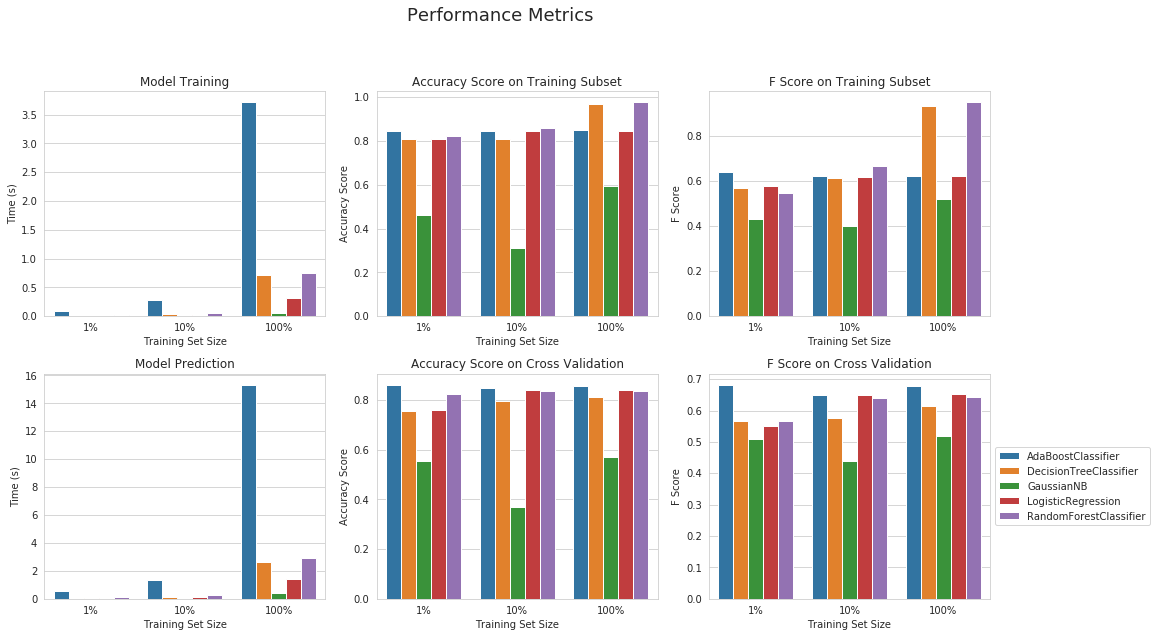

In [49]:
# then plot using Seaborn
with sns.axes_style('whitegrid',{'axes.facecolor':'white'}):
    f, axes = plt.subplots(2,3, figsize=(14,8))
    plt.suptitle('Performance Metrics', y=1.1, fontsize=18)
    sns.barplot(x='dataP',y='train_time',hue='model',data=df2, ax=axes[0][0])
    axes[0][0].set_title('Model Training')
    axes[0][0].set_xlabel('Training Set Size')
    axes[0][0].set_ylabel('Time (s)')
    axes[0][0].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='acc_train',hue='model',data=df2, ax=axes[0][1])
    axes[0][1].set_title('Accuracy Score on Training Subset')
    axes[0][1].set_xlabel('Training Set Size')
    axes[0][1].set_ylabel('Accuracy Score')
    axes[0][1].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='f1_train',hue='model',data=df2, ax=axes[0][2])
    axes[0][2].set_title('F Score on Training Subset')
    axes[0][2].set_xlabel('Training Set Size')
    axes[0][2].set_ylabel('F Score')
    axes[0][2].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='pred_time',hue='model',data=df2, ax=axes[1][0])
    axes[1][0].set_title('Model Prediction')
    axes[1][0].set_xlabel('Training Set Size')
    axes[1][0].set_ylabel('Time (s)')
    axes[1][0].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='acc_cv',hue='model',data=df2, ax=axes[1][1])
    axes[1][1].set_title('Accuracy Score on Cross Validation')
    axes[1][1].set_xlabel('Training Set Size')
    axes[1][1].set_ylabel('Accuracy Score')
    axes[1][1].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='f1_cv',hue='model',data=df2, ax=axes[1][2])
    axes[1][2].set_title('F Score on Cross Validation')
    axes[1][2].set_xlabel('Training Set Size')
    axes[1][2].set_ylabel('F Score')
    axes[1][2].get_legend().set_visible(False)
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5))

In [50]:
# inspect performance scores
df2

,model,level_1,train_time,pred_time,acc_train,acc_cv,f1_train,f1_cv,dataP
0,AdaBoostClassifier,0,0.082363,0.548728,0.843333,0.861501,0.641221,0.682374,1%
1,AdaBoostClassifier,1,0.287307,1.353371,0.846667,0.848770,0.622951,0.648649,10%
2,AdaBoostClassifier,2,3.718548,15.334371,0.850000,0.856207,0.621849,0.678611,100%
3,DecisionTreeClassifier,0,0.002776,0.025453,0.806667,0.756084,0.567164,0.566687,1%
4,DecisionTreeClassifier,1,0.030013,0.138860,0.806667,0.794859,0.613333,0.575502,10%
5,DecisionTreeClassifier,2,0.721337,2.618697,0.970000,0.810626,0.934307,0.615891,100%
6,GaussianNB,0,0.001559,0.019512,0.460000,0.553994,0.429577,0.508423,1%
7,GaussianNB,1,0.006387,0.055419,0.310000,0.369641,0.400000,0.439094,10%
8,GaussianNB,2,0.059158,0.386921,0.593333,0.571800,0.519685,0.519216,100%
9,LogisticRegression,0,0.002038,0.048877,0.810000,0.758999,0.577778,0.550216,1%


### Performance analysis

- AdaBoost had the best cross-validation performance for all dataset sizes
- Decision Tree and Logistic regression performed well with just the training set (probably overfitting)
- AdaBoost had by far the longest training time. However, it was still in the seconds range, so this comparison has no practical significance.

### Plotting the decision boundaries

I was curious to see how the multidimensional decision boundaries looked like when projected on the planes defined by the numerical variables. Here is the result.

In [53]:
def plotModel(clf, df, col1, col2, ax, nPlot):
#def plotModel(clf, df, col1, col2, nPlot):
    nPoints = nPlot**2
    df2 = df[0:nPoints].copy()
    X = df2[col1]
    Y = df2[col2]
    x_min, x_max = X.min() , X.max()
    y_min, y_max = Y.min() , Y.max() 
    xRange = np.linspace(x_min, x_max, num=nPlot)
    yRange = np.linspace(y_min, y_max, num=nPlot)
    xx, yy = np.meshgrid(xRange, yRange)
    df3 = pd.DataFrame(list(product(xx.ravel(),yy.ravel())), columns=[col1,col2])
    df2.update(df3[col1])
    df2.update(df3[col2])
    Z = clf.predict(df2)
    Z = Z.reshape(xx.shape)

#    fig, ax = plt.subplots(1)
    ax.set_title(str(clf.__class__.__name__))
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.contourf(xx, yy, Z, cmap = plt.cm.RdYlBu, alpha=0.5)
    scFig = ax.scatter(df2.iloc[0:nPoints,df2.columns.get_loc(col1)], 
           df2.iloc[0:nPoints,df2.columns.get_loc(col2)], c=y_train[0:nPoints], cmap='RdYlBu', s=2)
    return scFig

In [54]:
numerical = np.array(['age', 'education-num','capital-gain','capital-loss','hours-per-week'])

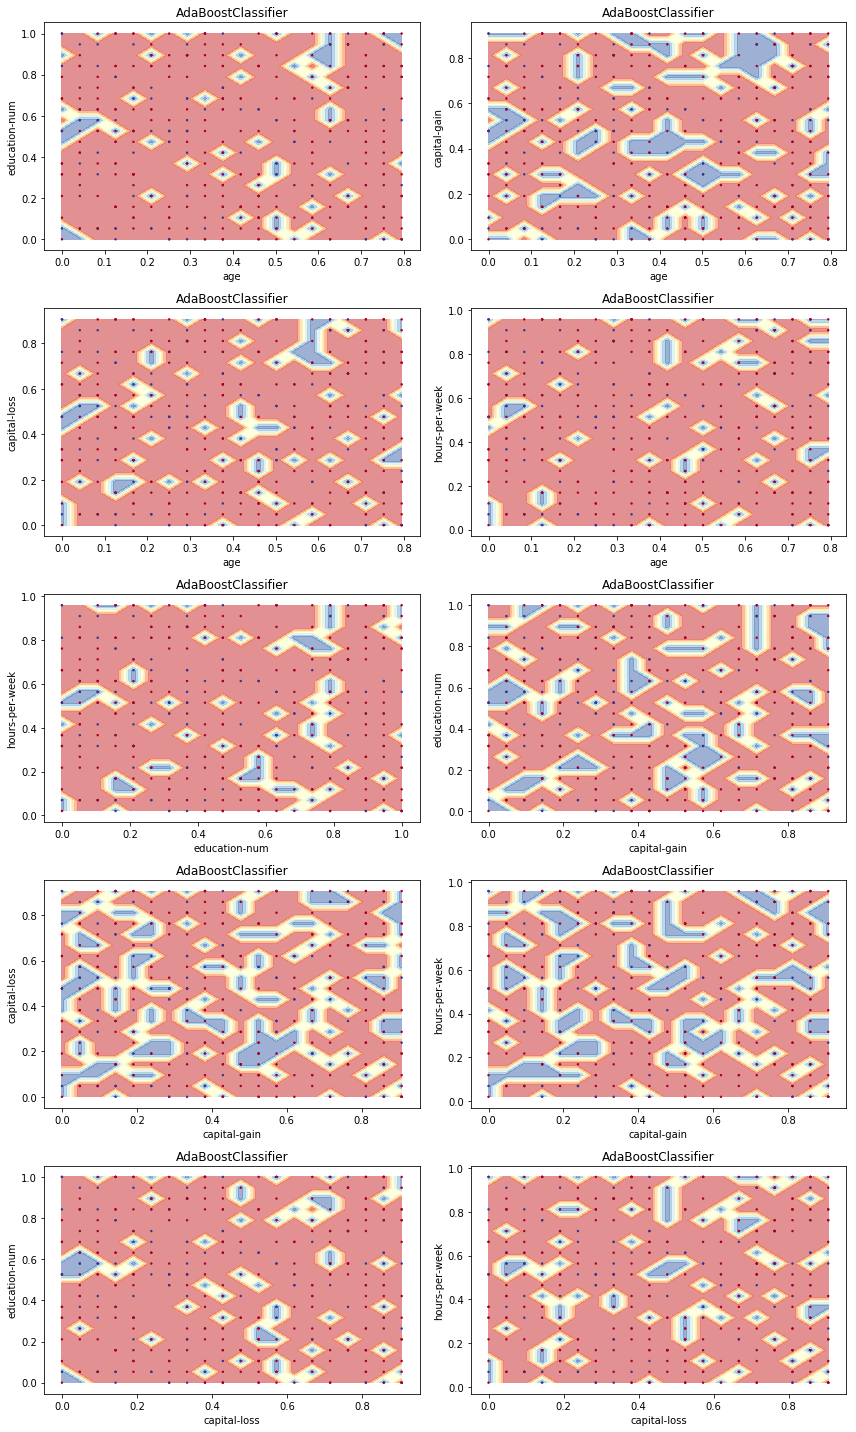

In [55]:
fig, axes = plt.subplots(int(len(numerical)),2,figsize=(12,20))

i_n = 0
j_n = 0
for i in numerical:
    for j in numerical:
        if i < j:
            plotModel(clf_B, X_train, i, j, axes[i_n][j_n], 20)
            j_n += 1
            if j_n == 2:
                j_n = 0
                i_n += 1
plt.tight_layout()

#### There was nothing special. What I found the most puzzling was the decision boundary for Logistic Regression. In 2D the boundary is linear but in higher dimension if becomes something quite convoluted (at least if I am not making any conceptual or coding mistake here)

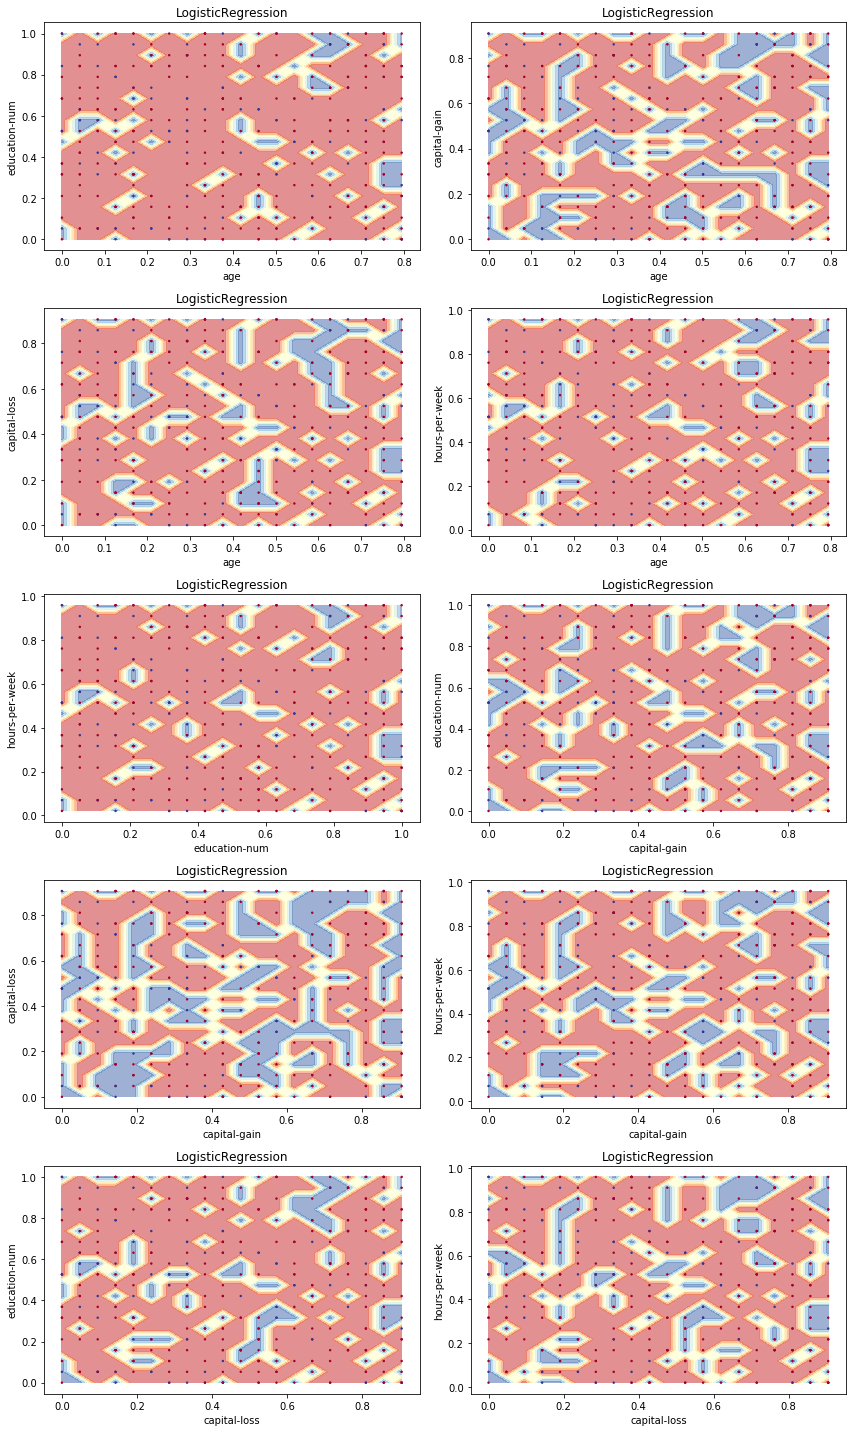

In [56]:
fig, axes = plt.subplots(int(len(numerical)),2,figsize=(12,20))

i_n = 0
j_n = 0
for i in numerical:
    for j in numerical:
        if i < j:
            plotModel(clf_C, X_train, i, j, axes[i_n][j_n], 20)
            j_n += 1
            if j_n == 2:
                j_n = 0
                i_n += 1
plt.tight_layout()

### Learning Curve Analysis

This part was not part of the original project. It was added to confirm that AdaBoost is not overfitting. 

In [58]:
def plotLearning(model,X,y):
    '''
        This function plots the learning curve for a given model.

        INPUT:
            model - instantiated sklearn model
            X - numpy array or pandas dataframe with training features
            y - numpy array or pandas dataframe with target values
    
        OUTPUT:
            graph with learning curves (Training scores and Testing scores)
    '''
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X,
                                                            y,
                                                            cv=3,
                                                            n_jobs=-1,
                                                            shuffle=True,
                                                       train_sizes=np.linspace(.1, 1.0, 10),
                                                           scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fig, ax = plt.subplots(1)
    
    ax.grid()
    ax.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, 
                 alpha=0.1, 
                 color='r')
    
    ax.set_xlabel('Elements in Training Set')
    ax.set_ylabel('F1 Score')
    ax.set_title(str(model.__class__.__name__))
    ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training scores')
    plt.legend()
    ax.fill_between(train_sizes,
                test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std,
                alpha=0.1,
                color='b')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Testing scores')
    plt.legend()

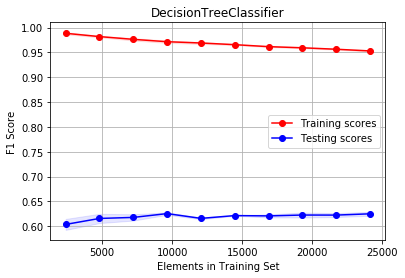

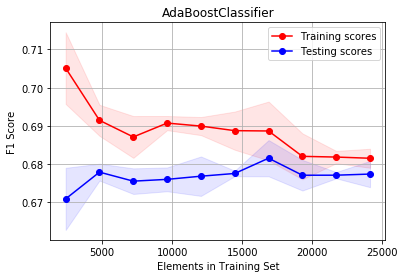

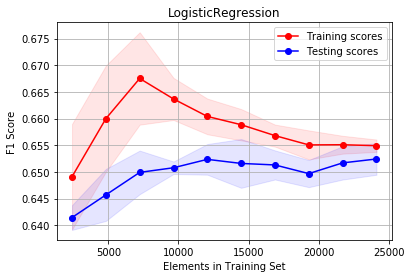

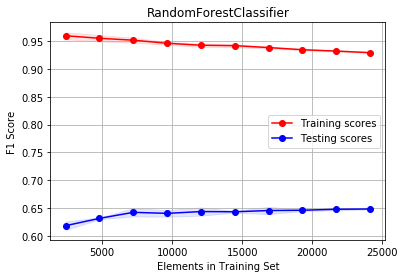

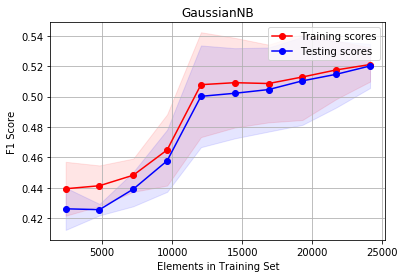

In [59]:
# plot learning curves for all models
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    plotLearning(clf, X_train, y_train)

#### Analysis of the learning curves:

-  Decision Tree was overfitting
-  AdaBoost and Logistic Regression showed balanced learning curves. However, AdaBoost had a higher score
-  Learning curve for GaussianNB showed improvement with the number of elements.

### Chosen model:


#### Adaboost was chosen the model to be used for the rest of this analysis. It had the best scores with the cross-validated set and it showed no signs of overfitting.

-  accuracy score with full training set: 0.856
-  F1 score with full training set: 0.679

#### They were both higher than the naive model. However, the F1 score was still quite small and some hyperparameter tuning was required.

In [69]:
clf_raw = clf_B
acc_raw = cross_val_score(clf_raw, X_train, y_train, cv=3, scoring='accuracy').mean()
f1_raw = cross_val_score(clf_raw, X_train, y_train, cv=3, scoring='f1').mean()

## Improving Results

Improving results involved tuning the hyperparameters of the model to determine an optimal configuration that maximized the F1 score.

### Random Search

We performed random search to probe different regions of the configuration space by randomly selecting combinations of the parameters. 

In [62]:
# parameters for random search
parameters = {"n_estimators": np.arange(100,2000,100),
            "learning_rate": np.arange(0.1,1.2,0.1),
              "algorithm":['SAMME','SAMME.R'],
              "base_estimator": [DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),
            DecisionTreeClassifier(max_depth=3)]  
}

In [65]:
# perform 200 iterations of random search
random_obj = RandomizedSearchCV(clf_raw, param_distributions=parameters, n_iter = 200)
random_obj.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=34),
          fit_params=None, iid='warn', n_iter=200, n_jobs=None,
          param_distributions={'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]), 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]), 'algorithm': ['SAMME', 'SAMME.R'], 'base_estimator':...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [66]:
# best random search estimator
clf_random = random_obj.best_estimator_
clf_random

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=800, random_state=34)

In [67]:
# accuracy of random estimator
acc_random = random_obj.best_score_
acc_random

0.8696409320839207

In [68]:
# f1 score for random estimator
f1_random = cross_val_score(clf_random, X_train, y_train, cv=3, scoring='f1').mean()
f1_random

0.7150823349976939

In [71]:
print('Raw model')
print('Accuracy score was {:.3f} and F1 score was {:.3f} for raw AdaBoost.'.format(acc_raw, f1_raw))
print('Random search model')
print('Accuracy score was {:.3f} and F1 score was {:.3f} for random AdaBoost.'.format(acc_random, f1_random))

Raw model
Accuracy score was 0.856 and F1 score was 0.677 for raw AdaBoost.
Random search model
Accuracy score was 0.870 and F1 score was 0.715 for random AdaBoost.


### Grid Search

We now performed grid search around the best result found by random search.

In [72]:
parameters = {"n_estimators": np.arange(780,820,10),
            "learning_rate": np.arange(0.05,0.15,0.01)
           }

In [73]:
# Define a F1 scorer that will evaluate the quality of solutions found in the grid
scorer = make_scorer(fbeta_score, beta=1.0)

In [74]:
# Generate a object for grid search
grid_obj = GridSearchCV(clf_raw, param_grid = parameters, cv=3, scoring=scorer, n_jobs=1)

In [75]:
# Run grid on training set
grid_obj.fit(X_train, y_train)

KeyboardInterrupt: 

In [198]:
# Select the instance with the best perfomance
clf_grid = grid_obj.best_estimator_
clf_grid

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.6, n_estimators=1440, random_state=34)

In [199]:
# f1 score improve
f1_grid = grid_obj.best_score_
f1_grid

0.7021474578396595

In [200]:
acc_grid = cross_val_score(clf_grid, X_train, y_train, cv=3, scoring='accuracy').mean()
acc_grid

0.8605743980982391

In [201]:
print('Raw model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_raw, f1_raw))
print('Random search model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_random, f1_random))
print('Grid search model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_grid, f1_grid))

Raw model
Accuracy score was 0.8559 and F1 score was 0.6774 for raw AdaBoost.
Random search model
Accuracy score was 0.8698 and F1 score was 0.7158 for raw AdaBoost.
Grid search model
Accuracy score was 0.8606 and F1 score was 0.7021 for raw AdaBoost.


There was a slight improvement using grid search.

### Calibrated model

In [202]:
from sklearn.calibration import CalibratedClassifierCV

In [203]:
clf_calibr = CalibratedClassifierCV(clf_grid, cv=3)
clf_calibr.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.6, n_estimators=1440, random_state=34),
            cv=3, method='sigmoid')

In [204]:
acc_calibr = cross_val_score(clf_calibr, X_train, y_train, cv=3).mean()
acc_calibr

0.8261326257014124

In [205]:
f1_calibr = cross_val_score(clf_calibr, X_train, y_train, cv=3, scoring='f1').mean()
f1_calibr

0.48092436181205267

In [206]:
calibr_proba = cross_val_predict(clf_calibr, X_train, y_train, cv=3, method='predict_proba')

In [207]:
fop, mpv = calibration_curve(y_train, calibr_proba[:,1], n_bins=10, normalize=True)

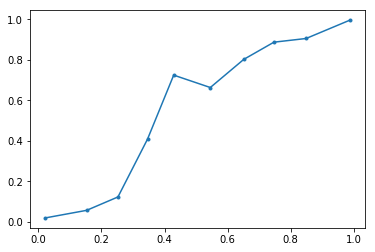

In [208]:
plt.plot(mpv, fop, marker='.')

In [209]:
print('Raw model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_raw, f1_raw))
print('Random search model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_random, f1_random))
print('Grid search model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_grid, f1_grid))
print('Calibrated model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_calibr, f1_calibr))

Raw model
Accuracy score was 0.8559 and F1 score was 0.6774 for raw AdaBoost.
Random search model
Accuracy score was 0.8698 and F1 score was 0.7158 for raw AdaBoost.
Grid search model
Accuracy score was 0.8606 and F1 score was 0.7021 for raw AdaBoost.
Calibrated model
Accuracy score was 0.8261 and F1 score was 0.4809 for raw AdaBoost.


The calibrated model slightly underperformed when compared to the grid model. We therefore take the grid model as the best model but we will also test the calibrated model with the test data to check if it generalizes better.

In [210]:
clf_best = clf_grid

------
## Evaluation of the best model

We will now apply tests to evaluate the best model.

### ROC curve for best model

In [211]:
clf_best_proba = cross_val_predict(clf_best, X_train, y_train, cv=3, method='predict_proba')

In [212]:
fpr, tpr, _ = roc_curve(y_train, clf_best_proba[:,1])

In [213]:
roc_auc = auc(fpr, tpr)
print('The area under the ROC curve is: ',roc_auc)

The area under the ROC curve is:  0.9055450702664382


Text(0, 0.5, 'True Positive Rate')

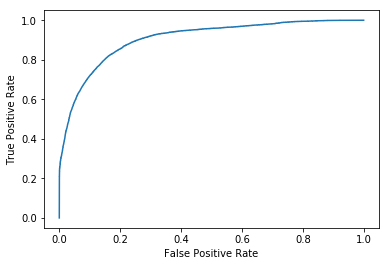

In [214]:
plt.plot(fpr, tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The ROC curve shows that the model is better than random guessing but the classifier is far from perfect.

### Precision Recall curve

In [215]:
from sklearn.metrics import precision_recall_curve

In [216]:
y_train_proba = clf_best.predict_proba(X_train)

In [217]:
y_train_proba.shape

(36177, 2)

In [218]:
y_train.shape

(36177,)

In [219]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_proba[:,1])

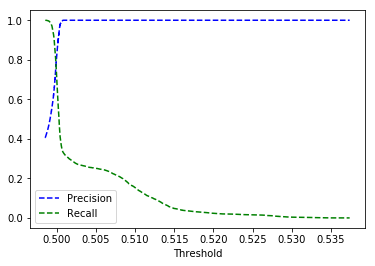

In [220]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g--', label="Recall")
plt.xlabel("Threshold")
plt.legend()

Threshold is located at 0.5. Was that obvious?

### Permutation score

Now we calculated the p-value for the F1 score calculated for the model. 

In [221]:
from sklearn.model_selection import permutation_test_score

In [222]:
score, permutation_scores, pvalue = permutation_test_score(
    clf_best, X_train, y_train, scoring="f1", cv=3, n_permutations=10, n_jobs=1)

In [223]:
score, pvalue

(0.7021474578396596, 0.09090909090909091)

The p-value is calculated as (C + 1) / (n_permutations + 1) where C is the number of permutations where the score is higher than the true score. Therefore the best possible value is 1 / (n_permutations + 1) = 1 / 11 = 0.0909. We conclude that the score calculated is significative. 

### Confusion matrix

In [224]:
from sklearn.metrics import confusion_matrix

In [225]:
y_train_pred = cross_val_predict(clf_best, X_train, y_train, cv=3)

In [226]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[25187,  1987],
       [ 3057,  5946]])

Confusion matrix shows a high number of false negatives. This certainly demands some investigation if some aspect of data cleaning was overlooked.

### Voting classifier

In [227]:
from sklearn.ensemble import VotingClassifier

In [228]:
clf_A = DecisionTreeClassifier(random_state=34)
clf_B = AdaBoostClassifier(random_state=34)
clf_C = LogisticRegression(random_state=34)
clf_D = RandomForestClassifier(random_state=34)
clf_E = GaussianNB()

In [229]:
#clf_voting = VotingClassifier(estimators=[('calibr', clf_calibr),
#                                          ('logReg', clf_C)], voting='hard')

In [230]:
# voting soft requires calibrated classifiers
clf_voting = VotingClassifier(estimators=[('calibr', clf_calibr),('logReg', clf_C)], voting='soft')

In [231]:
clf_voting.fit(X_train, y_train)

/home/bmartins/miniconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier(estimators=[('calibr', CalibratedClassifierCV(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impuri..., penalty='l2', random_state=34, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [232]:
f1_voting = cross_val_score(clf_voting, X_train, y_train, cv=3, scoring='f1').mean()
f1_voting

/home/bmartins/miniconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bmartins/miniconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bmartins/miniconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6495198268594048

No improvement here. Classifier clf_grid is still the best one.

## Scoring with Testing set

Now we finally applied the test set to assess the best classifier.

In [233]:
acc_test = clf_best.score(X_test, y_test) # this is accuracy
acc_test

0.8666666666666667

In [234]:
f1_test = f1_score(y_test, clf_best.predict(X_test))
f1_test

0.7074235807860262

In [235]:
f1_score(y_test, clf_calibr.predict(X_test))

0.48586810228802146

In [236]:
acc_raw_test = clf_raw.score(X_test, y_test) # this is accuracy
acc_raw_test

0.8576008844665561

In [237]:
f1_raw_test = f1_score(y_test, clf_raw.predict(X_test)) # this is accuracy
f1_raw_test

0.6739240506329114

In [238]:
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(acc_raw_test))
print("F-score on testing data: {:.4f}".format(f1_raw_test))
print("\nOptimized optimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(acc_test))
print("Final F-score on the testing data: {:.4f}".format(f1_test))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.6739

Optimized optimized Model
------
Final accuracy score on the testing data: 0.8667
Final F-score on the testing data: 0.7074


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

In [239]:
clf_best.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.6, n_estimators=1440, random_state=34)

In [240]:
# Construct dataframe containing feature labels and their weights
feature_importances = pd.DataFrame(clf_best.feature_importances_, 
                                   index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

In [241]:
feature_importances.head(n=5)

,importance
age,0.165250
hours-per-week,0.133240
education-num,0.062002
capital-loss,0.029667
capital-gain,0.029461


In [242]:
feature_importances.reset_index(inplace=True)

In [243]:
# Add cumulative sum of weights as a separate column
feature_importances['cumsum'] = np.cumsum(feature_importances['importance'])

In [244]:
feature_importances.head()

,index,importance,cumsum
0,age,0.165250,0.165250
1,hours-per-week,0.133240,0.298489
2,education-num,0.062002,0.360491
3,capital-loss,0.029667,0.390158
4,capital-gain,0.029461,0.419620


In [245]:
importance = clf_best.feature_importances_

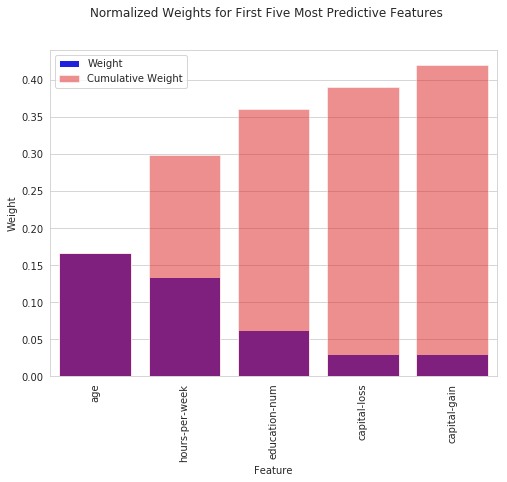

In [246]:
with sns.axes_style('whitegrid',{'axes.facecolor':'white'}):
    fig, axis = plt.subplots(1,1, figsize=(8,6))
    plt.suptitle('Normalized Weights for First Five Most Predictive Features')
    sns.barplot(x='index',
                y='importance',
                data=feature_importances.iloc[:5], 
                ax=axis, 
                color='blue', 
                ci=None, label='Weight')
    sns.barplot(x='index',
                y='cumsum',
                data=feature_importances.iloc[:5], 
                ax=axis, 
                color='red', 
                alpha=0.5, 
                ci=None, label='Cumulative Weight')
    plt.xticks(rotation=90)
    plt.legend()
    axis.set_xlabel('Feature')
    axis.set_ylabel('Weight')

Capital gain and capital loss are the features that are the most important to explain the variance.

### Feature Selection

In [247]:
from sklearn.base import clone

In [248]:
# Colect the first five columns in descending order of importance
X_train_reduced = X_train[X_train.columns.values[np.argsort(importance)[::-1][:5]]]

In [249]:
# Clone best model obtained above and train it with reduced training set
clf_fs = (clone(clf_best)).fit(X_train_reduced, y_train)

In [250]:
# Predictions with reduced test set
f1_fs = cross_val_score(clf_fs, X_train_reduced, y_train, cv=3, scoring='f1').mean()

In [251]:
acc_fs = cross_val_score(clf_fs, X_train_reduced, y_train, cv=3, scoring='accuracy').mean()

In [252]:
# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on CV: {:.4f}".format(acc_grid))
print("F-score on CV: {:.4f}".format(f1_grid))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on CV: {:.4f}".format(acc_fs))
print("F-score on CV: {:.4f}".format(f1_fs))

Final Model trained on full data
------
Accuracy on CV: 0.8606
F-score on CV: 0.7021

Final Model trained on reduced data
------
Accuracy on CV: 0.8378
F-score on CV: 0.6006


### RFE feature selection

In [253]:
from sklearn.feature_selection import RFE

In [254]:
clf_RFE = RFE(clf_best, 5, step = 1)

In [255]:
clf_RFE.fit(X_train, y_train)

RFE(estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.6, n_estimators=1440, random_state=34),
  n_features_to_select=5, step=1, verbose=0)

In [256]:
X_train.columns[clf_RFE.support_].value

AttributeError: 'Index' object has no attribute 'value'

In [ ]:
acc_rfe = clf_RFE.score(X_train, y_train)

In [ ]:
f1_rfe = cross_val_score(clf_RFE, X_train, y_train, cv=3, scoring='f1').mean()
f1_rfe

### Select K Best

In [ ]:
from sklearn.feature_selection import SelectKBest

In [ ]:
from sklearn.feature_selection import chi2

In [ ]:
clf_kb = (clone(clf_best))

In [ ]:
X_train2 = X_train.copy()

In [ ]:
X_train2 = SelectKBest(chi2, k=5).fit_transform(X_train2, y_train)

In [ ]:
clf_kb.fit(X_train2, y_train)

In [ ]:
cross_val_score(clf_kb, X_train2, y_train, cv=3, scoring='f1').mean()

### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 15)

In [ ]:
X_train2 = X_train.copy()

In [ ]:
pca.fit(X_train2)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
X_pca = pca.fit_transform(X_train2)

In [ ]:
cross_val_score(clf_best, X_pca, y_train, cv=3, scoring='f1').mean()

In [ ]:
import dill
dill.dump_session('finding_donors.db')

### TODO

-  Feature selection improved - done
-  Plot classification results - done
-  calculate p-value for score - done
-  calculate p-value for coefficients of logistic regression
-  ROC curve
-  AdaBoost Grid SearchCV - try optmizing trees - done
- print adaboost tree - not possible

### TODO - Naive Bayes

-  sklearn.calibration.CalibratedClassifierCV
   -   https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV
-  multinomialNB for categorical and GaussianNB for numerical. Multiply predict_proba or use probabilities as input ofr another GaussianNB classification.